In [2]:
import pandas as pd
import ast
import nltk
import re
from string import punctuation
import matplotlib.pyplot as plt
import numpy as np
import gensim
import json
import pickle
from shapely.geometry import shape
from nltk.util import ngrams
import pyLDAvis.gensim
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
tweets = pd.read_csv('tweets_at_trump.csv')
tweets = tweets.drop(['Unnamed: 0'], axis=1)
tweets = tweets.drop(['index'], axis=1)
tweets = tweets.drop(['user'], axis=1)

In [4]:
tweets['source'].value_counts()

android    3112
Other      2647
iphone      591
windows     289
ipad        119
web          76
macos        50
Name: source, dtype: int64

<BarContainer object of 5 artists>

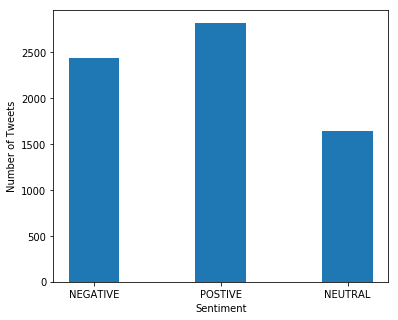

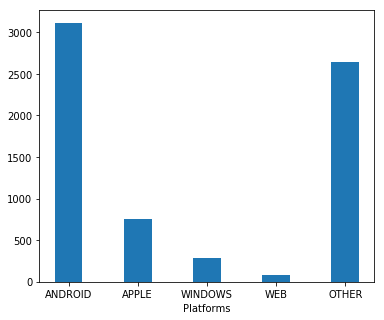

In [5]:
neutral = 0
neg = 0
pos = 0

for t in tweets['sentiment_type']:
    if t == 'NEUTRAL': 
        neutral += 1
    elif t == 'NEGATIVE':
        neg += 1
    else:
        pos += 1

droid = 0
apple = 0
windows = 0
web = 0
other = 0
for s in tweets['source']:
    if s == 'android':
        droid += 1
    elif s == 'iphone' or s == 'ipad' or s == 'macos':
        apple += 1
    elif s == 'web':
        web += 1
    elif s == 'windows':
        windows += 1
    else:
        other += 1

source_counts = {'ANDROID': droid, 'APPLE': apple, 'WINDOWS': windows, 'WEB': web, 'OTHER': other}
type_counts = {'NEGATIVE': neg, 'POSTIVE': pos, 'NEUTRAL': neutral}

plt.figure(figsize=(6,5))
plt.ylabel('Number of Tweets')
plt.xlabel('Sentiment')
plt.bar(list(type_counts.keys()), list(type_counts.values()), width=0.4)

plt.figure(figsize=(6,5))
plt.xlabel('Platforms')
plt.bar(list(source_counts.keys()), list(source_counts.values()), width=0.4)

# Group the tweets by location

The tweets are grouped by location and then each group's corresponding dataframe is added to a list. This list will be used to build an LDA model for each group of tweets to extract topics for each place individually.

In [81]:
tweets['zipcode'] = tweets.zipcode.astype('category')
places = tweets['place'].unique()

tweets_by_place = []
df_by_place = tweets.groupby('place')

for i in range(len(places)):
    tweets_by_place.append(df_by_place.get_group(places[i]))

The tweets are then cleaned and removed of stop words. Each tweet is then converted to a bigram. The tokenized tweets are used as a dictionary and as a corpus for the LDA model implemented by Gensim.

In [19]:
en_stop = set(nltk.corpus.stopwords.words('english'))
tok_twts = []
n = 2
for tweet in tweets['tweet']:
    tokens = nltk.tokenize.word_tokenize(tweet)
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [token.lower() for token in tokens]
    ngrams = zip(*[tokens[i:] for i in range(n)])
    tokens = [" ".join(ngram) for ngram in ngrams]
    tok_twts.append(tokens)
    
dictionary = gensim.corpora.Dictionary(tok_twts)
corpus = [dictionary.doc2bow(tweet) for tweet in tok_twts]

In [20]:
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

C:\Users\nazbi\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:160: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, keywords, defaults = inspect.getargspec(kallable)


In [37]:
NUM_TOPICS = 12
ldamodel = gensim.models.ldamodel.LdaModel(corpus, iterations=50, num_topics=NUM_TOPICS, id2word=dictionary, passes=20)
ldamodel.save('model.gensim')

C:\Users\nazbi\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:160: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, keywords, defaults = inspect.getargspec(kallable)
C:\Users\nazbi\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:160: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, keywords, defaults = inspect.getargspec(kallable)
C:\Users\nazbi\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:160: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, keywords, defaults = inspect.getargspec(kallable)


In [30]:
x = ldamodel.print_topics()

In [38]:
from gensim.models.coherencemodel import CoherenceModel
cm = CoherenceModel(model=ldamodel, corpus=corpus, coherence='u_mass')
cm.get_coherence()

0.5617708938970447